# Домашнее задание 3. Детекция объектов



Сыграем в квиддич? Или лучше в карты?



В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.



Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.



Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.



Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.





Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)



### А ещё есть консультация 2023 года :)



https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes



Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(



По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.



Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные



Скачайте один из датасетов на свой вкус и начните работу с ним.

Разметка находится в xmls папке, картинки в images.

# Задача 1. 0.5 балла.



Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [1]:
import torch

from xml.etree import ElementTree as ET

import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2

from pathlib import Path

import glob

import numpy as np

from PIL import Image

import torchvision

from torchvision.models import ResNet50_Weights

from tqdm.notebook import tqdm

from torch import nn

import shutil

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2024-11-25 07:31:40--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-25 07:31:40--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: 'data.zip'

data.zip            100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2024-11-25 07:31:41 (265 MB/s) - 'data.zip' saved [38392108/38392108]



Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
import xml.etree.ElementTree as ET

def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # Get something like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]

    # Read the XML file
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()

    # Iterate over bboxes
    bboxes = []

    for member in treeroot.findall("object"):
        # Extract bounding box coordinates and class label
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        # Extract the class label and map it to its index using class_dict
        class_name = member.find("name").text
        class_index = class_dict[class_name]

        # [xmin, ymin, xmax, ymax, class]
        res = [xmin, ymin, xmax, ymax, class_index]

        bboxes.append(res)

    return bboxes


In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)

test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.



Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.



В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.





Полезные функции:

* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure

* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)

* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):

    mean = (0.485, 0.456, 0.406)

    std = (0.229, 0.224, 0.225)



    fig, axes = plt.subplots(

        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100

    )



    for i, ax in enumerate(axes.reshape(-1)):



        ax.axis(False)



        if i >= len(images):

            break

        image = images[i].permute(1, 2, 0).cpu().numpy()  # Преобразуем
        image = image * np.array(std) + np.array(mean)  # Откат нормализации

        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # Вот тут покажите картинку после отката нормализации

        ax.imshow(np.clip(image, 0, 1))



        for bbox in bboxes[i]:

            xmin, ymin, xmax, ymax, class_idx = bbox
            class_name = train_ds.class_dict_inv[class_idx]

            # Рисуем прямоугольник
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Добавляем текст с названием класса
            ax.text(
                xmin, ymin, class_name, color='red',
                fontsize=8, verticalalignment='bottom', horizontalalignment='left'
            )


    fig.tight_layout()

    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

In [8]:
import matplotlib.patches as patches

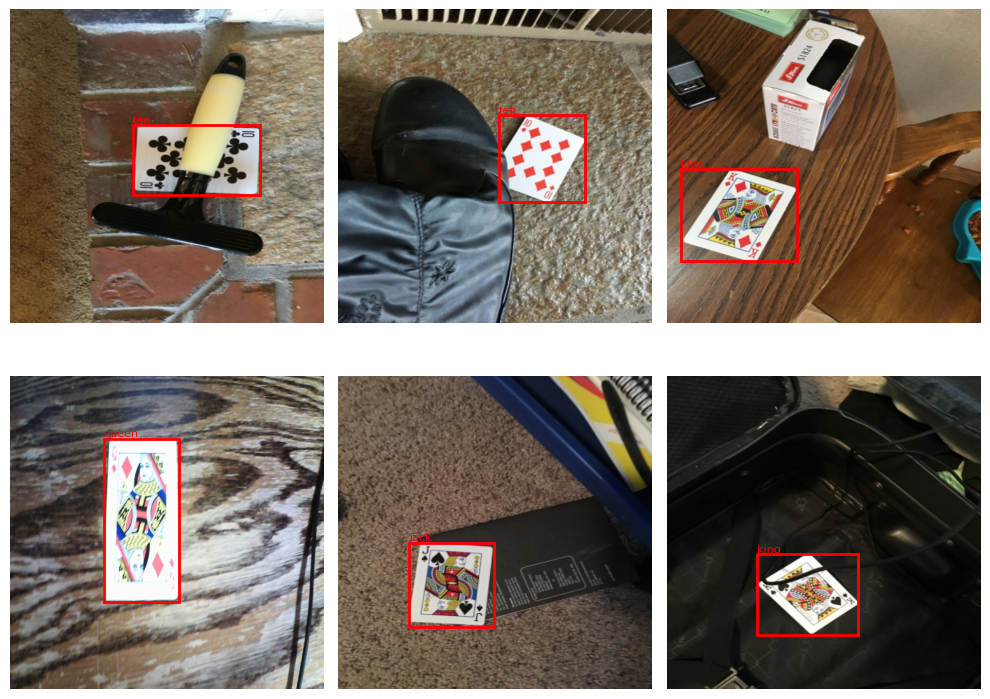

In [9]:
out = [train_ds[i] for i in range(6)]

visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.

## YOLO-like детектор



Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.



Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).



Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код. 



В шести "каналах" у нас будут записаны:

* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)

* Нормализованные ширина и высота bbox. 2 канала (W, H)

* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал

* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.



Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)



![image](https://i.imgur.com/13YVxAd.jpeg)

In [10]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, zip(*[(b["image"], b["bboxes"]) for b in batch]))
    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    # Создаем пустой таргет
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):

        # Преобразуем список боксов в тензор
        boxes = imgs.new_tensor(boxes) 
        xmin, ymin, xmax, ymax, classes = boxes.T 

        # Размер клетки
        x_cell = downsample
        y_cell = downsample

        w_box = (xmax - xmin) / w  # Нормализованная ширина
        h_box = (ymax - ymin) / h  # Нормализованная высота

        # Центры боксов
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        # Индексы клеток
        cx_idx = torch.floor(cx / x_cell).long()
        cy_idx = torch.floor(cy / y_cell).long()

        # Сдвиги внутри клеток
        cx_box = (cx % x_cell) / x_cell
        cy_box = (cy % y_cell) / y_cell

 
        stacked_values = torch.stack([cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes], dim=0)
        target[i, :, cy_idx, cx_idx] = stacked_values

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [11]:
def test_collate_fn() -> None:
    

    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class

    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class

    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

 

    result = collate_fn([

        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },

        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }

    ])


    # Проверяем размерности

    assert result['image'].shape == (2, 3, 512, 512)

    assert result['target'].shape == (2, 6, 16, 16)

 

    # Проверяем значения клеточек, в которые попали ббоксы

    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))

    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))

    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

 

    # Проверяем, что все остальные клеточки содержат нули

    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)

    assert np.allclose(result['target'], 0)

 

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

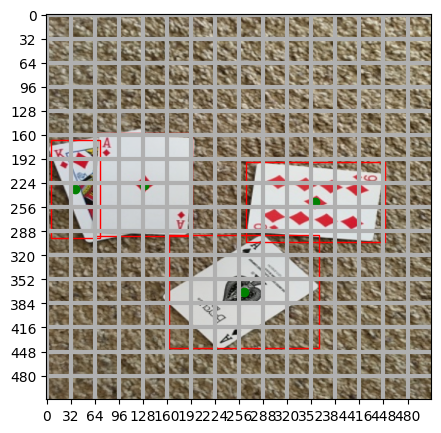

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

i = 20



img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(

    1, 1, -1

) + torch.tensor(mean).view(1, 1, -1)

bboxes = torch.tensor(train_ds[i]["bboxes"])



ax.imshow(img)

loc = plt.matplotlib.ticker.MultipleLocator(base=32)

ax.xaxis.set_major_locator(loc)

ax.yaxis.set_major_locator(loc)

ax.grid(which="major", axis="both", linestyle="-", linewidth=3)



for bbox in bboxes:

    xmin, ymin, xmax, ymax = bbox[:-1]

    w = xmax - xmin

    h = ymax - ymin

    with_mask = bbox[-1]

    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))



cx = (bboxes[:, 0] + bboxes[:, 2]) / 2

cy = (bboxes[:, 1] + bboxes[:, 3]) / 2



ax.scatter(cx, cy, color="green", marker="o")



plt.show()

## Задача 3.2. 0.5 балла.



Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему? 



Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.



Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 



То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.



Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [14]:
def decode_predictions(predictions, scale=32, threshold=0.7):
    batch_size, num_channels, grid_height, grid_width = predictions.shape
    decoded_results = []
    
    for batch_idx in range(batch_size):
        bounding_boxes = []
        center_x_offset, center_y_offset, box_width, box_height, confidence_scores = predictions[batch_idx, :5]
        
        if num_channels == 6:
            # Для target
            class_indices = predictions[batch_idx, 5].long()
        else:
            # Для выхода сети
            confidence_scores, class_indices = torch.max(predictions[batch_idx, 5:], dim=0)
        
        # Обходим сетку
        for grid_y in range(grid_height):
            for grid_x in range(grid_width):
                if confidence_scores[grid_y, grid_x] < threshold:
                    continue
                
                # Вычисление координат
                x_min = ((grid_x + center_x_offset[grid_y, grid_x].item()) * scale) - \
                        (box_width[grid_y, grid_x].item() * (grid_width * scale)) / 2
                y_min = ((grid_y + center_y_offset[grid_y, grid_x].item()) * scale) - \
                        (box_height[grid_y, grid_x].item() * (grid_height * scale)) / 2
                x_max = ((grid_x + center_x_offset[grid_y, grid_x].item()) * scale) + \
                        (box_width[grid_y, grid_x].item() * (grid_width * scale)) / 2
                y_max = ((grid_y + center_y_offset[grid_y, grid_x].item()) * scale) + \
                        (box_height[grid_y, grid_x].item() * (grid_height * scale)) / 2
                
                object_class = class_indices[grid_y, grid_x].item()
                bounding_boxes.append([x_min, y_min, x_max, y_max, object_class])
        
        decoded_results.append(bounding_boxes)
    
    return decoded_results


Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [15]:
def test_decode_predictions() -> None:

    # Применяем collate_fn к некоторым данным

    target1 = [ [ 100, 200, 200, 300, 2 ] ]

    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]

    result = collate_fn([

        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },

        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }

    ])

 

    target = result['target']

    assert target.shape == (2, 6, 16, 16)

    # В таком виде target соответствует поиску одного класса - 6-ой канал.

    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов

    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала

    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

 

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2

    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0

    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

 

    # Считаем результат

    actual = decode_prediction(target)

    print('Actual:  ', actual)

 

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.

    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.

    expected = [ target1, [ target2[1], target2[0] ] ]

    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.

    print('Expected:', expected)

 

    # Сравниваем

    assert actual == expected

 

test_decode_predictions()

Actual:   [[[100.0, 200.0, 200.0, 300.0, 2]], [[0.0, 100.0, 100.0, 300.0, 1], [0.0, 250.0, 200.0, 300.0, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.

Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.



Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [16]:
len(train_ds.class_dict_inv)

6

In [17]:
C = 6

In [18]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class Detector(nn.Module):
    def __init__(self, num_classes):
        super(Detector, self).__init__()
        
        # Используем ResNet50 как базовую сеть
        backbone_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Экстракция признаков до layer4 включительно
        self.feature_extractor = nn.Sequential(
            backbone_model.conv1,
            backbone_model.bn1,
            backbone_model.relu,
            backbone_model.maxpool,
            backbone_model.layer1,
            backbone_model.layer2,
            backbone_model.layer3,
            backbone_model.layer4
        )
        
        # Дополнительные сверточные слои
        self.prediction_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2048, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(128, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            ),
            nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)
        ])
        
        # Активация для нормализации выходов
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        # Пропускаем через экстрактор признаков
        x = self.feature_extractor(x)
        
        # Последовательно через дополнительные слои
        for layer in self.prediction_layers:
            x = layer(x)
        
        # Применяем сигмоиду для вывода
        return self.output_activation(x)

## Задача 3.4. 0.5 балла.



Реализуйте функцию потерь.



Для этого:

* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)

* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)

    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект

    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект

    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу

    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)





* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [19]:
def special_loss(pred, target, C=6):
    # Разделение предсказаний на соответствующие компоненты
    pred_coords = pred[:, :2, :, :]  # Координаты центра
    pred_dims = pred[:, 2:4, :, :]   # Размеры боксов
    pred_conf = pred[:, 4, :, :]     # Уверенность
    pred_classes = pred[:, 5:, :, :] # Классы

    target_coords = target[:, :2, :, :]
    target_dims = target[:, 2:4, :, :]
    target_conf = target[:, 4, :, :]
    target_classes = target[:, 5, :, :].long()
    obj_mask = target_conf > 0.5

    # Лосс для координат
    coord_loss = F.mse_loss(
        pred_coords.masked_select(obj_mask.unsqueeze(1)),
        target_coords.masked_select(obj_mask.unsqueeze(1)),
    )
    # Лосс для размеров
    dims_loss = F.mse_loss(
        torch.sqrt(pred_dims).masked_select(obj_mask.unsqueeze(1)),
        torch.sqrt(target_dims).masked_select(obj_mask.unsqueeze(1)),
    )
    # Лосс для классификации
    class_loss = F.cross_entropy(
        pred_classes.permute(0, 2, 3, 1)[obj_mask],  # [B, H, W, C] -> [N, C]
        target_classes[obj_mask],
    )
    # Лосс для уверенности
    conf_loss_obj = F.binary_cross_entropy_with_logits(
        pred_conf[obj_mask],
        target_conf[obj_mask],
    )
    conf_loss2 = F.binary_cross_entropy_with_logits(
        pred_conf[~obj_mask],
        target_conf[~obj_mask],
        reduction='sum',
    ) * 0.1 

    # Общий лосс
    total_loss = coord_loss + dims_loss + class_loss + conf_loss_obj + conf_loss2
    return total_loss

# Задача 4. 2 балла.



Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [21]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Установим количество эпох
EPOCHS = 15

# Инициализируем модель и оптимизатор
model = Detector(6).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Фиксируем случайные числа для воспроизводимости
torch.manual_seed(21)

# Смешанное вычисление для экономии памяти
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    model.train()
    progress_bar = tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}")
    losses_per_epoch = []

    for batch_data in progress_bar:
        imgs = batch_data["image"].to(device)
        tgts = batch_data["target"].to(device)

        with torch.cuda.amp.autocast():  # Автокастинг для смешанных вычислений
            predictions = model(imgs)
            current_loss = special_loss(predictions, tgts, C=len(train_ds.class_dict))

        opt.zero_grad()
        # Используем масштабирование градиентов
        scaler.scale(current_loss).backward()
        scaler.step(opt)
        scaler.update()

        losses_per_epoch.append(current_loss.item())
        progress_bar.set_description(f"Batch Loss: {current_loss.item():.3f}")

    avg_loss = np.mean(losses_per_epoch)
    print(f"Epoch {epoch + 1} completed; Average Training Loss: {avg_loss:.3f}")

/tmp/ipykernel_30/827163550.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_30/827163550.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Автокастинг для смешанных вычислений

Training Progress:   7%|▋         | 1/15 [00:12<02:48, 12.00s/it]   

Epoch 1 completed; Average Training Loss: 211.783



Training Progress:  13%|█▎        | 2/15 [00:23<02:32, 11.70s/it]   

Epoch 2 completed; Average Training Loss: 179.383



Training Progress:  20%|██        | 3/15 [00:34<02:18, 11.57s/it]   

Epoch 3 completed; Average Training Loss: 177.363



Training Progress:  27%|██▋       | 4/15 [00:46<02:06, 11.54s/it]   

Epoch 4 completed; Average Training Loss: 176.779



Training Progress:  33%|███▎      | 5/15 [00:57<01:55, 11.51s/it]   

Epoch 5 completed; Average Training Loss: 176.518



Training Progress:  40%|████      | 6/15 [01:09<01:43, 11.49s/it]   

Epoch 6 completed; Average Training Loss: 176.378



Training Progress:  47%|████▋     | 7/15 [01:20<01:31, 11.49s/it]   

Epoch 7 completed; Average Training Loss: 176.291



Training Progress:  53%|█████▎    | 8/15 [01:32<01:20, 11.44s/it]   

Epoch 8 completed; Average Training Loss: 176.239



Training Progress:  60%|██████    | 9/15 [01:43<01:08, 11.39s/it]   

Epoch 9 completed; Average Training Loss: 176.166



Training Progress:  67%|██████▋   | 10/15 [01:54<00:57, 11.43s/it]  

Epoch 10 completed; Average Training Loss: 176.132



Training Progress:  73%|███████▎  | 11/15 [02:06<00:45, 11.45s/it]  

Epoch 11 completed; Average Training Loss: 176.097



Training Progress:  80%|████████  | 12/15 [02:17<00:34, 11.44s/it]  

Epoch 12 completed; Average Training Loss: 176.070



Training Progress:  87%|████████▋ | 13/15 [02:29<00:22, 11.44s/it]  

Epoch 13 completed; Average Training Loss: 176.060



Training Progress:  93%|█████████▎| 14/15 [02:40<00:11, 11.41s/it]  

Epoch 14 completed; Average Training Loss: 176.063



Training Progress: 100%|██████████| 15/15 [02:52<00:00, 11.47s/it]  

Epoch 15 completed; Average Training Loss: 176.052


Запустим обученный детектор на тестовых изображениях:pbar

In [22]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [23]:
# Нужно сделать предсказание и переложить результат на cpu
images = batch['image'].to(device)
model.eval()
with torch.no_grad():
    predictions = model(images).cpu()

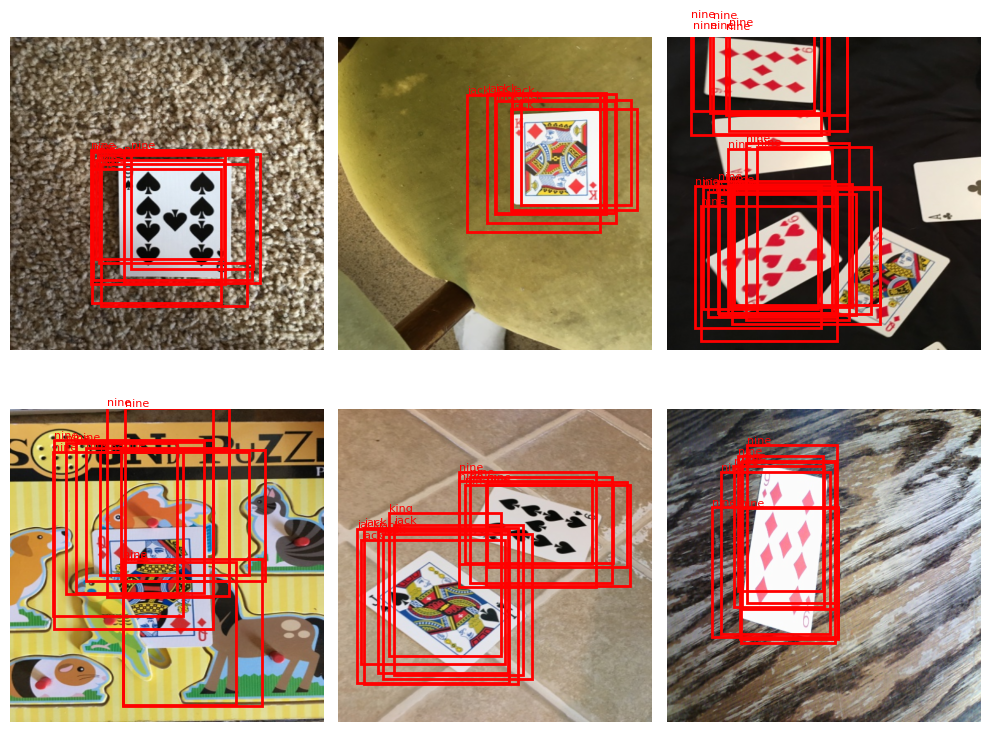

In [32]:
decoded_predictions = decode_prediction(predictions, threshold=0.99)
visualize(images, decoded_predictions)

In [33]:
from torchvision.ops import nms

In [36]:
final_predictions = []
for predictions_per_image in decoded_predictions:
    bbox_coordinates = torch.tensor([prediction[:4] for prediction in predictions_per_image], dtype=torch.float32)
    confidence_scores = torch.tensor([prediction[4] for prediction in predictions_per_image], dtype=torch.float32)
    selected_indices = nms(bbox_coordinates, confidence_scores, 0.0001)
    selected_boxes = [predictions_per_image[idx] for idx in selected_indices]
    valid_boxes = [box for box in selected_boxes if (box[2] - box[0]) * (box[3] - box[1]) >= 256]
    final_predictions.append(valid_boxes)

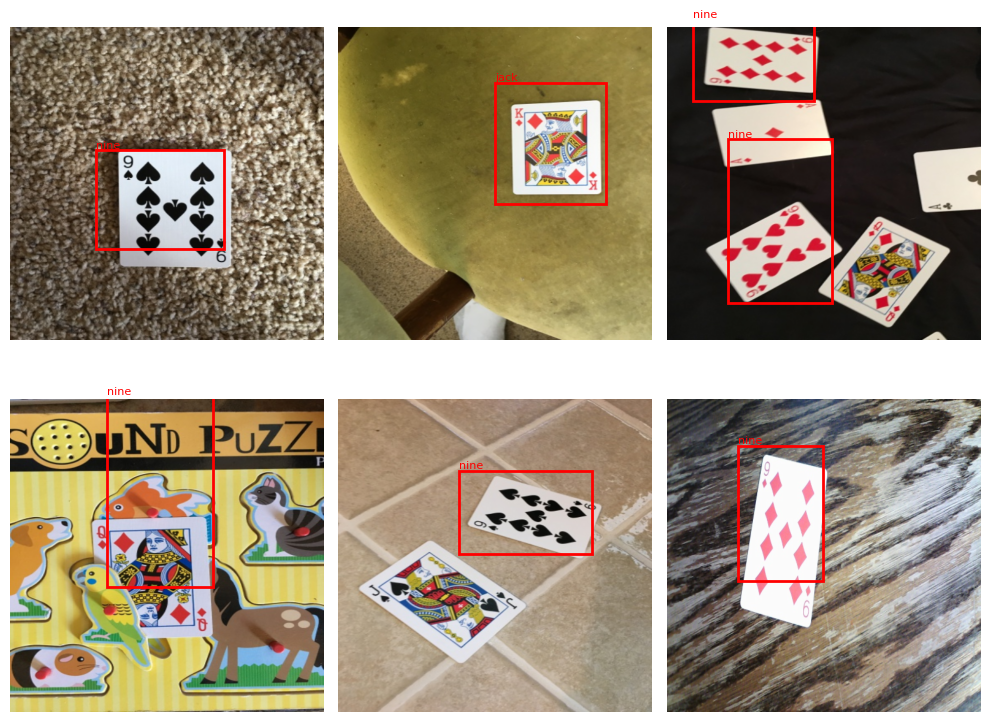

In [37]:
visualize(images, final_predictions)

# Задача 5. 3.5 балла.



Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.



Для этого будем использовать YOLO 11 от ultralytics.

In [38]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 20.4 MB/s eta 0:00:0000:01


## Задача 5.1. 1.5 балла.



Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).



Если коротко:

* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия

* Есть папочки train valid (их поможем вам собрать), в них две подпапки:

    - Первая images, в ней лежат картинки

    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [39]:
# Делаем папочки

!rm -rf train

!rm -rf valid

!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.



Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [93]:
def annotation2txt(bounding_boxes, image_width, image_height):
    yolo_format_annotations = []
    for box in bounding_boxes:
        x_start, y_start, x_end, y_end, category_id = box

        x_center = ((x_start + x_end) / 2) / image_width
        y_center = ((y_start + y_end) / 2) / image_height
        box_width = (x_end - x_start) / image_width
        box_height = (y_end - y_start) / image_height

        yolo_format_annotations.append(f"{category_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    return yolo_format_annotations

In [94]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [95]:
# Собираем YAML
nc =  len(train_ds.class_dict_inv)

names =  list(train_ds.class_dict_inv.values())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.



Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.



Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)



Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):



https://github.com/ultralytics/ultralytics/issues/1149



https://github.com/ultralytics/yolov5/issues/6907



https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [96]:
from ultralytics import YOLO

model = YOLO('yolo11n.yaml')
model.train(data="data.yaml", epochs=50, imgsz=640)

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

train: Scanning /kaggle/working/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1237.92it/s]

train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/valid/labels... 37 images, 0 backgrounds, 3 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1684.39it/s]

val: WARNING ⚠️ /kaggle/working/valid/images/cam_image2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0542      1.5979      1.0503      1.6124]
val: WARNING ⚠️ /kaggle/working/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /kaggle/working/valid/images/cam_image7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4272      1.4233]
val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/train20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train20
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.09G      2.995      4.646      4.416         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         34         60   0.000845      0.161    0.00202   0.000486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.18G       2.99      4.471      4.125         19        640: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         34         60    0.00155      0.202    0.00185   0.000548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.23G      2.931      4.199      3.856         36        640: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         34         60   0.000605      0.187    0.00123   0.000383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.23G      2.843      3.997      3.657         16        640: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

                   all         34         60    0.00149      0.197    0.00245   0.000746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.24G      2.823      3.834      3.469         23        640: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

                   all         34         60    0.00278      0.416     0.0442     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.24G      2.755      3.772      3.322         16        640: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34         60      0.258      0.085     0.0606     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.17G      2.627      3.561      3.157         24        640: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         34         60     0.0297      0.125     0.0282     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.19G      2.616      3.336      3.107         31        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         34         60      0.117      0.261      0.137     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.22G      2.475      3.231      2.969         25        640: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

                   all         34         60      0.202      0.411      0.242      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.23G      2.275      3.064      2.823         22        640: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         34         60      0.159      0.497      0.233      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.17G      2.122      2.903      2.685         20        640: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         34         60      0.451       0.21      0.266      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.19G      2.022      2.787      2.589         16        640: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

                   all         34         60      0.231      0.326      0.263      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.23G      1.929      2.697      2.529         18        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         34         60      0.226      0.534      0.264      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.2G      1.836      2.582      2.404         23        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         34         60      0.244      0.615      0.305      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.2G      1.743      2.478       2.33         16        640: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         34         60      0.271      0.564      0.345      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.2G      1.673      2.413      2.261         19        640: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         34         60      0.318      0.713      0.443      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.23G      1.603      2.371      2.193         18        640: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         34         60       0.42      0.524      0.356      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.18G      1.537      2.257      2.113         26        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

                   all         34         60      0.336      0.744      0.459      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.2G      1.504      2.199      2.059         26        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         34         60      0.411      0.597      0.498      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.19G      1.461      2.146      2.026         32        640: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         34         60      0.516      0.519      0.508      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.23G      1.417      2.116      1.987         29        640: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

                   all         34         60      0.361      0.773      0.502      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.19G      1.468      2.174      1.999         14        640: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         34         60      0.305      0.537      0.503      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.17G      1.365      2.002      1.898         23        640: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         34         60       0.38      0.747      0.533      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.2G      1.301      1.996      1.856         27        640: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all         34         60      0.355      0.628      0.502      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.23G      1.321      2.015      1.849         24        640: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         34         60      0.434      0.726      0.503      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.19G      1.249      1.902      1.783         25        640: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         34         60      0.444       0.68      0.515      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.19G      1.298      1.884      1.831         23        640: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

                   all         34         60      0.392      0.737       0.55      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.19G       1.29      1.919      1.805         28        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         34         60       0.42      0.804      0.579       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.22G      1.231      1.848      1.758         27        640: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         34         60      0.422      0.669      0.628      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.25G      1.208      1.789      1.729         20        640: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         34         60      0.443      0.784      0.627      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.19G      1.206      1.827      1.735         32        640: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

                   all         34         60      0.452      0.885      0.629      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.2G      1.159      1.754      1.675         23        640: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         34         60      0.415      0.841      0.567      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.22G      1.142      1.754      1.654         28        640: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

                   all         34         60      0.403      0.856       0.58      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.23G      1.111      1.693       1.62         20        640: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         34         60      0.449      0.876      0.606       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.2G      1.158      1.739      1.668         31        640: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

                   all         34         60      0.477      0.817      0.649      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.2G      1.096      1.689      1.599         17        640: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         34         60      0.468      0.869      0.647      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.22G      1.057      1.646       1.59         20        640: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         34         60      0.434      0.918      0.663      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.23G      1.074      1.654      1.592         16        640: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         34         60      0.437      0.845      0.655      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.2G      1.122      1.689      1.635         32        640: 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

                   all         34         60      0.489      0.881      0.672      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.17G       1.06      1.645      1.581         21        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         34         60       0.47      0.865      0.661      0.561


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.23G      0.911      1.725      1.429         10        640: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         34         60      0.495      0.809       0.65      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.17G     0.8526      1.604      1.381         12        640: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         34         60      0.498      0.885       0.61      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.17G     0.8314      1.584      1.356         15        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]

                   all         34         60      0.527      0.796      0.679      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.18G     0.8345      1.523      1.356          9        640: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         34         60      0.472      0.899      0.645      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.2G     0.8405      1.507      1.354          6        640: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

                   all         34         60      0.466      0.795      0.675       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.21G     0.8203      1.507      1.341         15        640: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         34         60       0.48      0.853      0.686      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.18G     0.7906      1.501      1.297          7        640: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         34         60       0.56      0.828      0.724      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.18G     0.8006      1.441      1.334         15        640: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         34         60      0.525      0.837      0.715      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.2G     0.7711      1.418       1.29         13        640: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         34         60       0.52      0.884      0.729      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.21G     0.7883      1.464      1.318         12        640: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         34         60      0.525      0.862      0.729      0.619



50 epochs completed in 0.077 hours.
Optimizer stripped from runs/detect/train20/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train20/weights/best.pt, 5.5MB

Validating runs/detect/train20/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]


                   all         34         60      0.524      0.861      0.729      0.619
                  king         10         11      0.372      0.818      0.716      0.653
                  jack          6          6      0.201      0.667       0.23      0.203
                   ace          5          6      0.756          1      0.948      0.875
                   ten          6          6      0.504          1      0.931      0.714
                  nine         15         17      0.716      0.941      0.897      0.699
                 queen         14         14      0.597      0.742       0.65      0.567
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train20


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7927355786d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Задание 5.3. 0.5 балла.



Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).



Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [97]:
results = model.predict(source="/kaggle/working/valid/images", save=True, name='my_predicts')


image 1/37 /kaggle/working/valid/images/IMG_2391.JPG: 640x480 1 nine, 46.7ms
image 2/37 /kaggle/working/valid/images/IMG_2399.JPG: 640x480 1 king, 8.2ms
image 3/37 /kaggle/working/valid/images/IMG_2400.JPG: 640x480 1 king, 1 jack, 1 queen, 7.9ms
image 4/37 /kaggle/working/valid/images/IMG_2405.JPG: 640x480 1 jack, 1 queen, 7.8ms
image 5/37 /kaggle/working/valid/images/IMG_2425.JPG: 640x480 1 king, 7.9ms
image 6/37 /kaggle/working/valid/images/IMG_2427.JPG: 640x480 1 king, 1 queen, 8.2ms
image 7/37 /kaggle/working/valid/images/IMG_2430.JPG: 640x480 1 king, 8.0ms
image 8/37 /kaggle/working/valid/images/IMG_2454.JPG: 640x480 1 nine, 8.2ms
image 9/37 /kaggle/working/valid/images/IMG_2457.JPG: 640x480 1 king, 1 jack, 1 queen, 7.8ms
image 10/37 /kaggle/working/valid/images/IMG_2473.JPG: 640x480 1 ace, 1 ten, 1 nine, 8.0ms
image 11/37 /kaggle/working/valid/images/IMG_2474.JPG: 640x480 1 ace, 1 nine, 7.9ms
image 12/37 /kaggle/working/valid/images/IMG_2488.JPG: 640x480 1 jack, 1 queen, 7.9ms
i

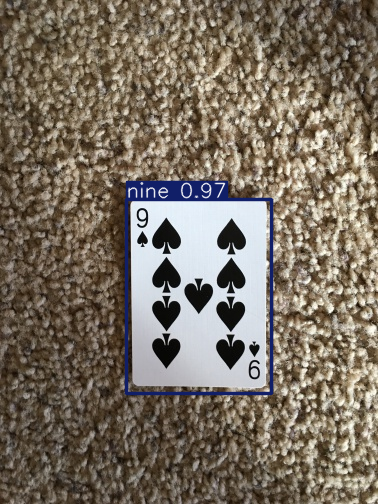

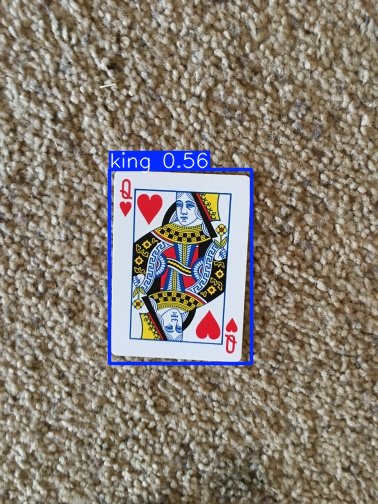

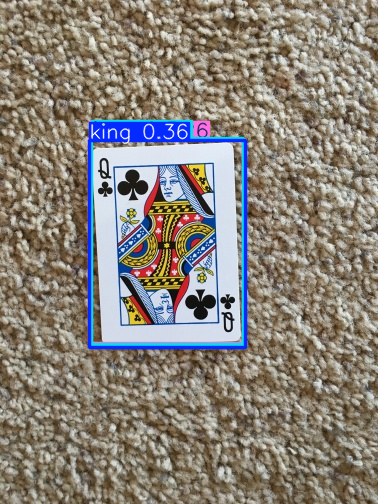

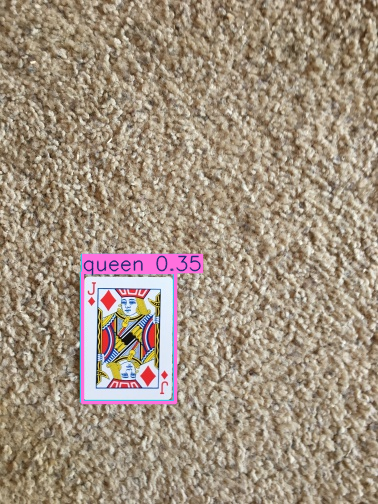

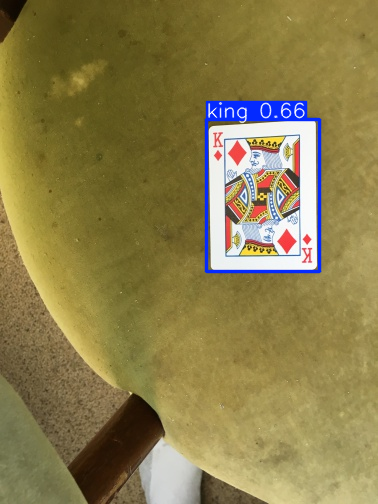

In [98]:
for i, r in enumerate(results[:5]):
    im_bgr = r.plot()  
    im_rgb = Image.fromarray(im_bgr[..., ::-1]) 
    r.show()